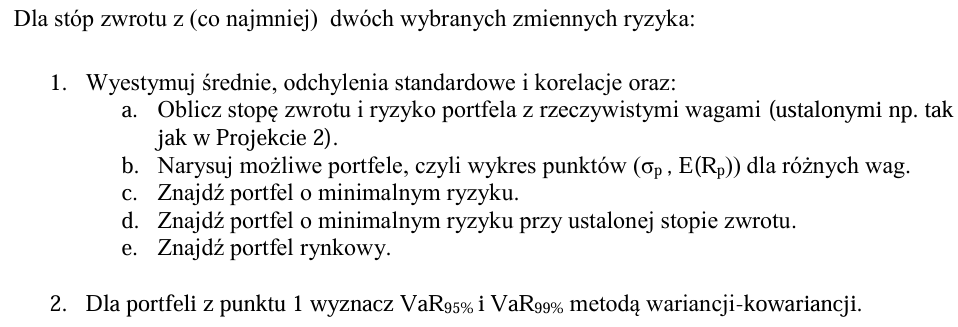

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import norm
import numpy as np
from scipy.optimize import minimize_scalar

In [51]:
# Wczytaj plik
df1 = pd.read_csv('fuel_output.csv', sep=';')
df2 = pd.read_csv('merged_output.csv', sep=';')
# Wyodrębnij kolumny do zmiennych
#dates = pd.to_datetime(df['Date'])

fuel_data = df1['fuel_data']
beef_data=df2['beef_data']

fuel_returns = np.log(fuel_data / fuel_data.shift(1)).dropna()
beef_returns = np.log(beef_data / beef_data.shift(1)).dropna()



# 1. Statystyki

In [52]:
### PALIWO
mean_returns_f = fuel_returns.mean()
std_devs_f = fuel_returns.std()
#cov_matrix = fuel_returns.cov()
#correlation = fuel_returns.corr()

print("Średnie stopy zwrotu:\n", mean_returns_f)
print("\nOdchylenia standardowe:\n", std_devs_f)


Średnie stopy zwrotu:
 0.0010584922842003712

Odchylenia standardowe:
 0.01686179481992683


In [53]:
### WOLOWINA
mean_returns_b = beef_returns.mean()
std_devs_b = beef_returns.std()

print("Średnie stopy zwrotu:\n", mean_returns_b)
print("\nOdchylenia standardowe:\n", std_devs_b)


Średnie stopy zwrotu:
 -0.00014511107802290383

Odchylenia standardowe:
 0.027503848821220696


In [ ]:
# KORELACJA MIEDZY NIMI
correlation = np.corrcoef(beef_returns,fuel_returns)
print(correlation)

[[1.         0.00780695]
 [0.00780695 1.        ]]


## a) stopa zwrotu i ryzyko portfela

In [57]:
cov_matrix=np.cov([beef_returns, fuel_returns])
mean_returns=np.array([mean_returns_b, mean_returns_f])
std_devs=np.array([std_devs_b, std_devs_f])

### TU TRZEBA DAC WAGI Z PORTFELA Z 2 PROJEKTU
weights = np.array([0.6, 0.4]) 
port_return = np.dot(weights, mean_returns)
port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

print(f"Stopa zwrotu portfela: {port_return:.4f}")
print(f"Ryzyko portfela (σ): {port_std:.4f}")


Stopa zwrotu portfela: 0.0003
Ryzyko portfela (σ): 0.0179


## b) wykres z wagami

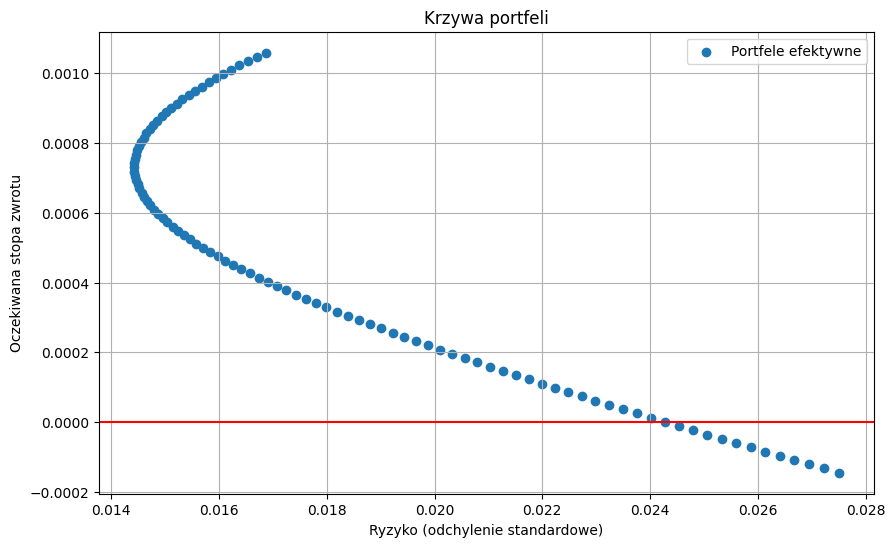

In [58]:
weights_range = np.linspace(0, 1, 100)
returns_list = []
stds_list = []

for w in weights_range:
    w_vec = np.array([w, 1-w])
    r = np.dot(w_vec, mean_returns)
    s = np.sqrt(np.dot(w_vec.T, np.dot(cov_matrix, w_vec)))
    returns_list.append(r)
    stds_list.append(s)

plt.figure(figsize=(10, 6))
plt.scatter(stds_list, returns_list, label="Portfele efektywne")
plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Krzywa portfeli")
plt.axhline(y=0, color='red')
plt.grid(True)
plt.legend()
plt.show()


## c) minimalne ryzyko

In [59]:
inv_cov = np.linalg.inv(cov_matrix)
ones = np.ones(len(mean_returns))
w_min_var = np.dot(inv_cov, ones) / np.dot(ones.T, np.dot(inv_cov, ones))

print("Wagi portfela minimalnego ryzyka:", w_min_var)


Wagi portfela minimalnego ryzyka: [0.27159023 0.72840977]


In [60]:
inv_cov = np.linalg.inv(cov_matrix)
ones = np.ones(len(mean_returns))

# wagi portfela minimalnego ryzyka
w_min_var = np.dot(inv_cov, ones) / np.dot(ones.T, np.dot(inv_cov, ones))

# stopa zwrotu i ryzyko tego portfela
r_min_var = np.dot(w_min_var, mean_returns)
std_min_var = np.sqrt(np.dot(w_min_var.T, np.dot(cov_matrix, w_min_var)))


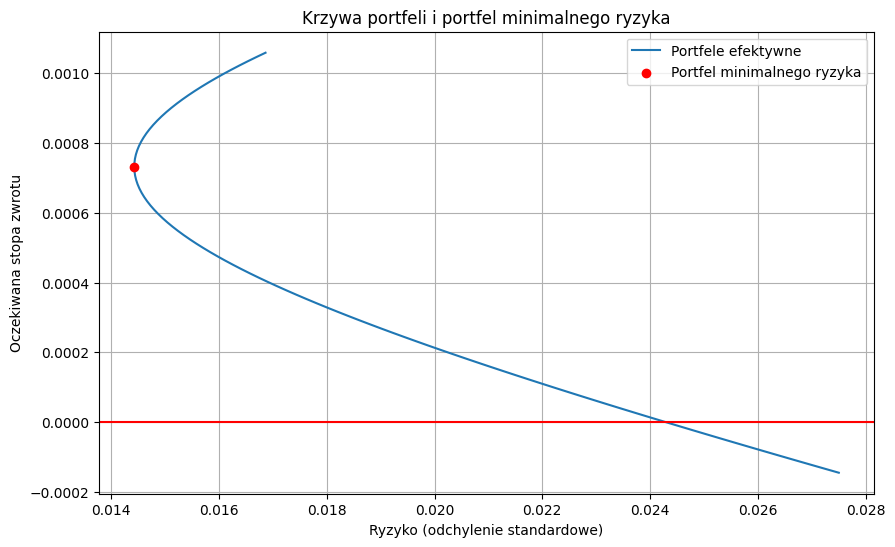

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(stds_list, returns_list, label="Portfele efektywne")
plt.scatter(std_min_var, r_min_var, color='red', label='Portfel minimalnego ryzyka', zorder=5)
plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Krzywa portfeli i portfel minimalnego ryzyka")
plt.grid(True)
plt.legend()
plt.axhline(y=0, color='red')
plt.show()


## d) minimalne ryzyko przy ustalonej cenie zwrotu - dokonczyc

In [62]:
target_return = 0.05

A = np.dot(mean_returns.T, np.dot(inv_cov, mean_returns))
B = np.dot(mean_returns.T, np.dot(inv_cov, ones))
C = np.dot(ones.T, np.dot(inv_cov, ones))
D = A * C - B ** 2

lambda_1 = (C * target_return - B) / D
lambda_2 = (A - B * target_return) / D

w_target = lambda_1 * np.dot(inv_cov, mean_returns) + lambda_2 * np.dot(inv_cov, ones)
print("Wagi portfela dla ustalonej stopy zwrotu:", w_target)


Wagi portfela dla ustalonej stopy zwrotu: [-40.66248837  41.66248837]


kod dla roznych oczekiwanych zwrotow?

In [36]:
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 100)
risks = []

for target_return in target_returns:
    A = np.dot(mean_returns.T, np.dot(inv_cov, mean_returns))
    B = np.dot(mean_returns.T, np.dot(inv_cov, ones))
    C = np.dot(ones.T, np.dot(inv_cov, ones))
    D = A * C - B ** 2

    lambda_1 = (C * target_return - B) / D
    lambda_2 = (A - B * target_return) / D

    w = lambda_1 * np.dot(inv_cov, mean_returns) + lambda_2 * np.dot(inv_cov, ones)
    sigma = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    risks.append(sigma)


## e) stopa wolna rynkowa 

In [67]:
returns = pd.concat([beef_returns, fuel_returns], axis=1)
#returns.columns = ['beef', 'fuel']  # nadaj nazwy, jeśli ich brak

# Teraz policz średnie i odchylenia jako Series z nazwami
mean_returns = returns.mean()
std_devs = returns.std()


In [70]:
r_f = 0.02

excess_returns = mean_returns - r_f
sharpe_ratios =pd.Series(excess_returns / std_devs)

# Portfel rynkowy = maksymalny wskaźnik Sharpe'a
best_idx = sharpe_ratios.idxmax()
print(f"Najlepszy składnik portfela rynkowego: {best_idx}")


Najlepszy składnik portfela rynkowego: beef_data


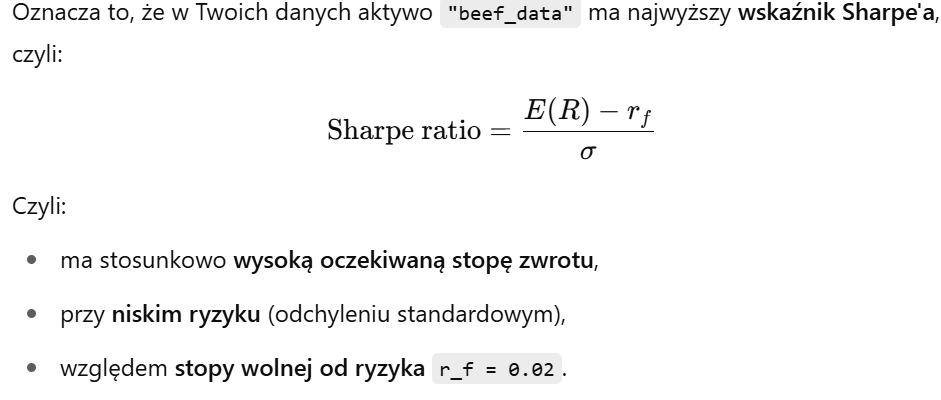

In [71]:
import numpy as np

# Stałe
inv_cov = np.linalg.inv(cov_matrix)
ones = np.ones(len(mean_returns))

# Tangency portfolio (maksymalny Sharpe ratio)
excess = mean_returns - r_f
w_market = np.dot(inv_cov, excess)
w_market /= np.sum(w_market)  # Normalizacja wag

# Parametry portfela rynkowego
R_market = np.dot(w_market, mean_returns)
σ_market = np.sqrt(np.dot(w_market.T, np.dot(cov_matrix, w_market)))

print(f"Portfel rynkowy:\nWagi: {w_market}\nOczekiwana stopa zwrotu: {R_market:.4f}\nRyzyko: {σ_market:.4f}")


Portfel rynkowy:
Wagi: [0.28416647 0.71583353]
Oczekiwana stopa zwrotu: 0.0007
Ryzyko: 0.0144


In [72]:
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 100)
risks = []

for R_target in target_returns:
    A = np.dot(mean_returns.T, np.dot(inv_cov, mean_returns))
    B = np.dot(mean_returns.T, np.dot(inv_cov, ones))
    C = np.dot(ones.T, np.dot(inv_cov, ones))
    D = A * C - B ** 2

    λ1 = (C * R_target - B) / D
    λ2 = (A - B * R_target) / D

    w = λ1 * np.dot(inv_cov, mean_returns) + λ2 * np.dot(inv_cov, ones)
    σ = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    risks.append(σ)


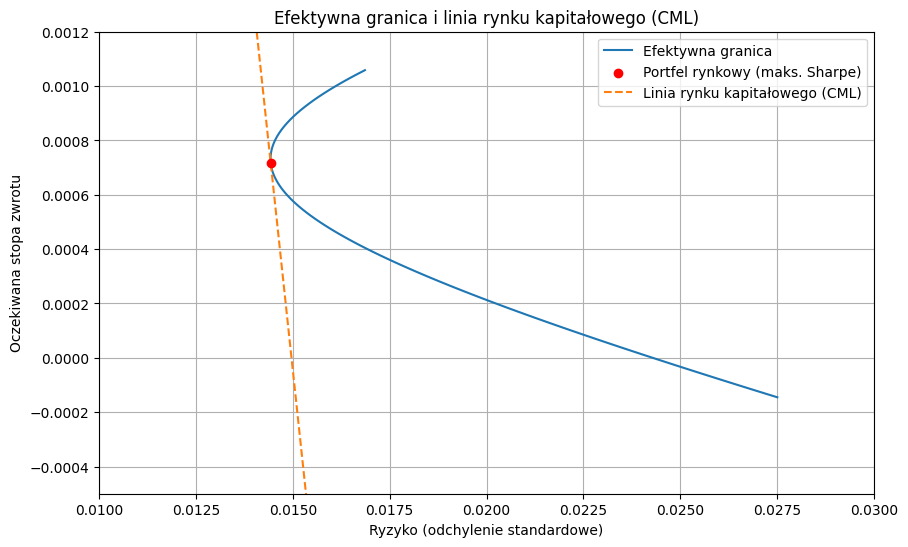

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Efektywna granica
plt.plot(risks, target_returns, label='Efektywna granica')

# Portfel rynkowy (tangency point)
plt.scatter(σ_market, R_market, color='red', label='Portfel rynkowy (maks. Sharpe)', zorder=5)

# CML – linia rynku kapitałowego
σ_cml = np.linspace(0, max(risks), 100)
R_cml = r_f + (R_market - r_f) / σ_market * σ_cml
plt.plot(σ_cml, R_cml, label='Linia rynku kapitałowego (CML)', linestyle='--')

# Oznaczenia
plt.xlabel("Ryzyko (odchylenie standardowe)")
plt.ylabel("Oczekiwana stopa zwrotu")
plt.title("Efektywna granica i linia rynku kapitałowego (CML)")
plt.ylim(-0.0005,0.0012)
plt.xlim(0.01,0.03)
plt.legend()
plt.grid(True)
plt.show()
